In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as atu
from analyze_tools.monte_carlo import get_colliding_time

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average

ROOT = os.path.expanduser('~/OneDrive - Emory/Research data/mm_polariton/pickle_jar')
assert os.path.isdir(ROOT)

In [2]:
#
# DEFINING FUNCTION
## WARNING: NEXT CELL WILL RUN SIMULATIONS
#


Lxy = 3e7; Lz = 3e3
def get_ArXePair(d_arxe, v_ar = 0, h = 0, n_pairs = 1, Lxy=Lxy, Lz=Lz):
    """
    """
    atoms = AtomsInBox(
        Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
        mass_dict = red.mass_dict)

    v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

    for i in range(n_pairs):
        if i == 0:
            r0 = np.zeros(3)
        else:
            r0 = np.hstack(
                [
                    #np.random.uniform(-Lxy/2+10, Lxy/2-10, size = 2), 
                    np.zeros(2),
                    np.random.uniform(-Lz/2+10, Lz/2-10)]
            )
        atoms.add(
                elements = ["Ar"],
                r = np.array([[0.0, h, -d_arxe/2]]) + r0,
                r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
                )
        
        atoms.add(
                elements = ["Xe"],
                r = np.array([[0.0,0.0,d_arxe/2]]) + r0,
                r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
                )
    
    idxAr = atoms.element_idx(element = "Ar")
    idxXe = atoms.element_idx(element = "Xe")
    epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)
    
    # calculator to the atoms object
    atoms.add_calculator(
        calculator_class = Calculator,
        calculator_kwargs = {
            "epsilon": epsilon_mat, "sigma" : sigma_mat, 
            "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
            "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
        })
    
    atoms.update_distance()
    
    return atoms

def get_field(coup_str, amplitude, T = None, mode = False, Lxy = Lxy, Lz = Lz, field = 'cavity'):
    if mode == 'multi':
        k_vector_int = np.array(
            [[i,0,0] for i in range(1,100)]
            ,dtype=np.float64)
    elif isinstance(mode, int):
        k_vector_int = np.array([[mode,0,0]])
    elif isinstance(mode, list):
        k_vector_int = np.array(
            [[i,0,0] for i in mode], 
            dtype = np.float64)
    else:
        raise Exception('Mode have to be either "multi" or an integer!')
    
    if field == 'cavity':
        VectorPotentialClass = CavityVectorPotential
    elif field == 'free':
        VectorPotentialClass = FreeVectorPotential
    
    Afield = VectorPotentialClass(
            k_vector_int = k_vector_int, amplitude = amplitude,
            Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = coup_str, T = T / red.temp
            )

    return Afield

def get_radprofile(rd, windows = 10):
    Afield = rd['field']
    
    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = at.profiling_rad(omega, rad_energy)
    
    sorted_idx = np.argsort(omega_profile)

    if windows == 0:
        omega_profile = np.array(omega_profile)[sorted_idx] 
        final_rad_profile = np.array(final_rad_profile)[sorted_idx]
    else:
        omega_profile, final_rad_profile = moving_average(
            np.array(omega_profile)[sorted_idx], 
            np.array(final_rad_profile)[sorted_idx], windows)

    return omega_profile, final_rad_profile

In [3]:
# 
# CALCULATING SPECTRA
# Run simulation of head on collision coupled to FREE field 
# at various total energy as temperature 
# 

result_dict = {}
velocity_dict = {}

for T in tqdm.tqdm(np.arange(92, 850, 10)):
    
    vt = np.sqrt((T * red.boltzmann / red.epsilon) )
    atoms = get_ArXePair(d_arxe = 6, h = 0.0 , v_ar = vt, n_pairs = 1)
    
    field = get_field(amplitude = 'zero', mode = list(range(1,300)), coup_str = 1, Lz = Lxy, field = 'free' , T = T)
        
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)

    result_dict.update({T : rd})
    velocity_dict.update({T : (vt, vt / np.sqrt(M_Xe))})

  0%|                                                                                                                                                                          | 0/76 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [ ]:
#
# PLOTTING SPECTRA
#

fig,ax = plt.subplots(2, figsize = (6,8))

total = 0

prob_list = []

for T in result_dict.keys():
    prob_list.append(T * np.exp(- T / 292))

prob_list = np.array(prob_list)
prob_list = prob_list / np.sum(prob_list)

for i, (T,rd) in enumerate(result_dict.items()):
    
    omega_profile, final_rad_profile = get_radprofile(rd,0 )
    final_rad_profile *= 1e25
    total += final_rad_profile * prob_list[i]

    if i % 5 == 0:
        ax[0].plot(
            omega_profile, final_rad_profile, label = 'T = {} K'.format(T), 
            linestyle = 'dashdot' if i >= 35 else None)

ax[1].plot(omega_profile, total, label = 'Scaled total spectrum')
  
tax = ax[1].twinx()
exp_data = pd.read_csv('data/plot-data.csv')
tax.scatter(
    exp_data.loc[:,'x'],
    exp_data.loc[:,' y'],
    s = 5, alpha = 0.5, c = 'black'
)
ax[1].scatter([],[], c = 'black', label = 'Exp. @ 292K')

ax[0].set_ylabel(r"Calculated EM field energy $(10^{-25} eV)$")
ax[1].set_ylabel(r"Sum of scaled EM field energy $(10^{-25} eV)$")
ax[1].set_xlabel(r"Wavenumber $(cm^{-1})$")

tax.set_ylabel(r'Exp. absorption $(10^{-6} cm^{-1} amagat^{-2})$')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.7), xycoords = 'axes fraction')

ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=4)
ax[1].legend()
fig.savefig('figure/manuscript/free_spectrum_singleT.jpeg',dpi = 600, bbox_inches = 'tight')

In [32]:
#
# Record (trajectory @ 40K, highest temperature that Ar-Xe complex form, previous temperature)
#

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = [0.0]#, 0.3, 0.6, 0.9, 1.2]
Tlist = list(np.arange(10, 150, 5))

cavity_init = 'zero'
save_path = 'pickle_jar/single_collision_{}_cavity'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

for ct in [20, 15, 10]:
    result_dict = {}
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        foo = {}
        
        for T in tqdm.tqdm(Tlist[::-1]):

            vt = np.sqrt((T * red.boltzmann / red.epsilon) )
            # T = K_Ar + K_Xe = 2K_Ar = m_Ar v_Ar^2 (equal kinetic energy of Argon and Xenon)
            atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1)
            
            field = get_field(
                amplitude = cavity_init, T = T,
                mode = list(range(1,100)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
            )
                
            t, rd = single_collision_simulation(
                0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                max_steps = 10000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

            foo.update({T:rd})
            
        result_dict.update({h : foo})

    with open(save_path + '/coup_str_{}.pkl'.format(ct),'wb') as handle:
        pickle.dump(result_dict, handle)
            

Load file?(Y)/N N


pickle_jar/single_collision_zero_cavity
h =  0.0  coupling strength =  20


 18%|████████████████████████████▉                                                                                                                                     | 5/28 [00:19<01:29,  3.90s/it]


KeyboardInterrupt: 

In [15]:
#
# Record (trajectory @ 40K, highest temperature that Ar-Xe complex form, previous temperature)
#

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = [0.0, 0.3, 0.6, 0.9, 1.2]
Tlist = list(np.arange(10, 106, 2))

cavity_init = 'zero'
save_path = 'pickle_jar/single_collision_{}_cavity_'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

for ct in [20, 15, 1e1]:
    foo = {}

    result_dict = {}
    
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        for T in tqdm.tqdm(Tlist[::-1]):

            vt = np.sqrt((T * red.boltzmann / red.epsilon) )
            atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1)
            
            field = get_field(
                amplitude = cavity_init, T = T,
                mode = list(range(1,100)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
            )
                
            t, rd = single_collision_simulation(
                0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                max_steps = 5000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

            collide_time = get_colliding_time(rd['atoms'], dipole_threshold = 0)[0]

            if collide_time > 10: 
                print('break @ {} K, with collide time {}ps'.format(T, collide_time))
                result_dict.update({h : {'break T':T, 'result_dict':rd}})
                break

    with open(save_path + '/coup_str_{}.pkl'.format(ct),'wb') as handle:
        pickle.dump(result_dict, handle)

Load file?(Y)/N N


pickle_jar/single_collision_zero_cavity
h =  0.0  coupling strength =  20


  2%|███▌                                                                                                                                                                    | 1/48 [00:24<19:20, 24.69s/it]


break @ 102 K, with collide time 101.60892535029511ps
h =  0.3  coupling strength =  20


 15%|████████████████████████▌                                                                                                                                               | 7/48 [00:59<05:47,  8.48s/it]


break @ 90 K, with collide time 101.17700643275931ps
h =  0.6  coupling strength =  20


 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 18/48 [01:26<02:24,  4.82s/it]


break @ 68 K, with collide time 100.05401724716624ps
h =  0.9  coupling strength =  20


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 29/48 [01:51<01:12,  3.84s/it]


break @ 46 K, with collide time 98.15357401000874ps
h =  1.2  coupling strength =  20


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 37/48 [02:05<00:37,  3.40s/it]

break @ 30 K, with collide time 95.51886861304038ps


h =  0.0  coupling strength =  15


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 27/48 [01:54<01:29,  4.25s/it]


break @ 50 K, with collide time 99.01741184508033ps
h =  0.3  coupling strength =  15


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 29/48 [02:01<01:19,  4.20s/it]


break @ 46 K, with collide time 98.58549292754454ps
h =  0.6  coupling strength =  15


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 33/48 [02:02<00:55,  3.70s/it]


break @ 38 K, with collide time 97.54888752545862ps
h =  0.9  coupling strength =  15


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 38/48 [02:12<00:34,  3.49s/it]


break @ 28 K, with collide time 95.62684834242434ps
h =  1.2  coupling strength =  15


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 43/48 [02:36<00:18,  3.64s/it]

break @ 18 K, with collide time 92.30107267739871ps


h =  0.0  coupling strength =  10.0


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 42/48 [02:30<00:21,  3.59s/it]


break @ 20 K, with collide time 94.22311186043301ps
h =  0.3  coupling strength =  10.0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 43/48 [02:39<00:18,  3.72s/it]


break @ 18 K, with collide time 93.46725375474536ps
h =  0.6  coupling strength =  10.0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 44/48 [02:38<00:14,  3.60s/it]


break @ 16 K, with collide time 92.45224429853624ps
h =  0.9  coupling strength =  10.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 46/48 [02:47<00:07,  3.65s/it]


break @ 12 K, with collide time 89.86073079332147ps
h =  1.2  coupling strength =  10.0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 47/48 [02:43<00:03,  3.48s/it]

break @ 10 K, with collide time 87.6795402597657ps


In [31]:
for i, file in enumerate(glob(ROOT + '/single_collision_zero_cavity_/*')):
    with open(file, 'rb') as handle:
        result_dict = pickle.load(handle)

        if '20' in file: coup_str = 20
        elif '10' in file: coup_str = 10
        elif '15' in file: coup_str = 15

        for h, rd in result_dict.items():
            print("{} & {} & {} \\\ ".format(coup_str, h, rd['break T']))

10 & 0.0 & 20 \\ 
10 & 0.3 & 18 \\ 
10 & 0.6 & 16 \\ 
10 & 0.9 & 12 \\ 
10 & 1.2 & 10 \\ 
20 & 0.0 & 102 \\ 
20 & 0.3 & 90 \\ 
20 & 0.6 & 68 \\ 
20 & 0.9 & 46 \\ 
20 & 1.2 & 30 \\ 
15 & 0.0 & 50 \\ 
15 & 0.3 & 46 \\ 
15 & 0.6 & 38 \\ 
15 & 0.9 & 28 \\ 
15 & 1.2 & 18 \\ 


In [28]:
result_dict

{0.0: {'break T': 50,
  'result_dict': {'atoms': <matter.atoms.AtomsInBox at 0x1400873e0>,
   'field': <field.electromagnetic.CavityVectorPotential at 0x1467c12e0>}},
 0.3: {'break T': 46,
  'result_dict': {'atoms': <matter.atoms.AtomsInBox at 0x154c550d0>,
   'field': <field.electromagnetic.CavityVectorPotential at 0x13f0e2690>}},
 0.6: {'break T': 38,
  'result_dict': {'atoms': <matter.atoms.AtomsInBox at 0x1465d31a0>,
   'field': <field.electromagnetic.CavityVectorPotential at 0x133928560>}},
 0.9: {'break T': 28,
  'result_dict': {'atoms': <matter.atoms.AtomsInBox at 0x12dd9d070>,
   'field': <field.electromagnetic.CavityVectorPotential at 0x151ade3f0>}},
 1.2: {'break T': 18,
  'result_dict': {'atoms': <matter.atoms.AtomsInBox at 0x14688ef00>,
   'field': <field.electromagnetic.CavityVectorPotential at 0x14ffa02c0>}}}

pickle_jar/single_collision_zero_cavity/coup_str_20.pkl
pickle_jar/single_collision_zero_cavity/coup_str_10.pkl
pickle_jar/single_collision_zero_cavity/coup_str_15.pkl


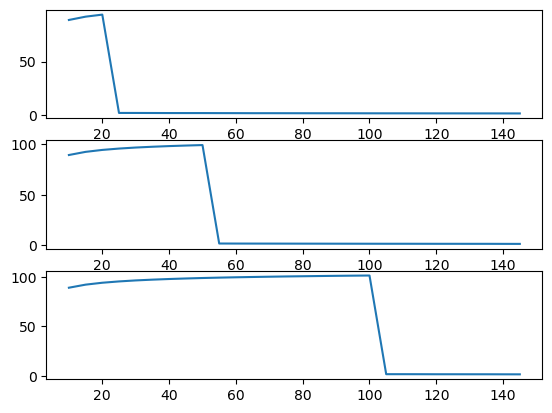

In [24]:
fig,ax = plt.subplots(3)


ROOT2 = 'pickle_jar'
for _, file in enumerate(glob(ROOT2 + '/single_collision_zero_cavity/*')):
    print(file)
    if '20' in file: i = 2
    elif '10' in file: i = 0
    elif '15' in file: i = 1
    with open(file, 'rb') as handle:
        result_dict = pickle.load(handle)
        
        #for h, foo in result_dict.items():
        foo = result_dict[0.0]
        collide_time_list = []
        T_list = []
        for T, rd in foo.items():
            collide_time = get_colliding_time(
                rd['atoms'], dipole_threshold = 0)[0]
            
            collide_time_list.append(collide_time)
            T_list.append(T)

        ax[i].plot(T_list, collide_time_list)
            
            
        

In [ ]:
print('coupling strength & h & total kinetic energy')
for i, (ct, dict1) in enumerate(single_collision_multimode_data.items()):
    for j, (h, data) in enumerate(dict1.items()):
        
        print("{} & {} & {} \\\\ ".format(ct, h, data[-1]))

In [ ]:
h = 1.0
coup_str = 15

atoms = single_collision_multimode_data[coup_str][h][0]['last']['atoms']

coltime = np.array(atm.get_colliding_time(atoms, 0))
result_idx = np.argmax(coltime)
print(coltime[result_idx])

field = single_collision_multimode_data[coup_str][h][0]['last']['field']

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,result_idx]
r_xe = np.array(atoms.trajectory['r'])[:,result_idx + N_pairs]

v_ar = np.array(atoms.trajectory['r_dot'])[:,result_idx]
v_xe = np.array(atoms.trajectory['r_dot'])[:,result_idx + N_pairs]

t = np.array(atoms.trajectory['t'])

In [ ]:
from calculator.function import LJ_potential

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = field.history['t']

fig,ax = plt.subplots(3,figsize = (10,12))
#ax[0].plot(t[200:], d[200:])
ax[0].plot(t, k)
ax[1].plot(t, v)
ax[2].plot(tem[300:], hem[300:])

#ax[0].set_xlim(t[0],t[-1])
ax[0].set_xlim(t[300],t[-1])
ax[1].set_xlim(t[300],t[-1])
ax[2].set_xlim(tem[300],tem[-1])

ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_major_formatter('{x:.0f}')

ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_major_formatter('{x:.0f}')

ax[2].xaxis.set_major_locator(MultipleLocator(5))
ax[2].xaxis.set_major_formatter('{x:.0f}')

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax[0].set_ylabel(r'Kinetic energy ($10^{-3}$ eV)')
ax[1].set_ylabel(r'Potential energy ($10^{-3}$ eV)')
ax[2].set_ylabel(r'Total cavity modes energy ($10^{-3}$ eV)')

ax[2].set_xlabel('Time (ps)')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

#fig.savefig(fig_root + 'energy_breakdown.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
an = importlib.reload(an)

an.single_anime(atoms, index = 0 , N_pairs = N_pairs, save_path = 'figure2/longest_single_anime')